In [1]:
import numpy as np
import pandas as pd
import datetime
import time
from demand_model import *
import pywt
from utils import *
from uncertainty_process import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## create DemandFile object, get basic date from it, date, date_ud, cusid, cusid_ud, and dataframe
Demandb = pd.read_csv('SelectedDataFor1EE.csv')
Demandbase = DemandFile(Demandb)
Date = Demandbase.getDate()
Date_ud = Demandbase.getDate_ud()
CusID = Demandbase.getCusID()
CusID_ud = Demandbase.getCusID_ud()

In [2]:
def inlist(dm,CLT):
    idbase = (dm['CustomerID'] == 0)
    for ind in CLT:
        tmpid = (dm['CustomerID'] == ind)
        idbase = idbase | tmpid
    return idbase
def rateCal(mlist):
    ori = np.mean(mlist[:-1])
    new = mlist[-1]
    rate = (ori - new)/ori
    return rate

In [3]:
import random
## setting data use parameters, set customers and dates which is taken into consideration
modset_c = ['fixed','period','list']
modset_d = ['fixed','period','list']
Cus = 1002
CusStart = 1002
CusEnd = 2000
Dateone = '2009-07-14' # this is a Monday
DateStart = '2009-09-04'#'2009-07-14'#'2009-09-04' ## including
DateEnd = '2010-05-21' ## not including, start from friday, then end on friday
DateList = ['2009-07-14', '2009-07-19']
time1 = time.time()

In [4]:
# all load profiles
DCL = 3 # decomposition level
## setting mode and get considering data
mod_c = 'list'
mod_d = 'period'
agmod = 'sum'
## initiate database
Demand = Demandbase.getDataframeAll()
indlist = random.sample(range(0,929), 929)
indlist = np.sort(indlist)
CusList = []
for i_ind in indlist:
    CusList.append(CusID_ud[i_ind])
# get data which comply with customer id conditions first, use switch code
for case in switch(mod_c):
    if case('fixed'):
        Demand = Demand[(Demand['CustomerID'] == Cus)]
        break
    if case('period'):
        Demand = Demand[(Demand['CustomerID'] >= CusStart) & (Demand['CustomerID'] < CusEnd)]
        break
    if case('list'):
        ils = inlist(Demand, CusList)
        Demand = Demand[inlist(Demand, CusList)]
        break
    if case():
        print "mod_c setting error #1"# get data which comply with date condition, then left only data comply with both cusid and date
print(Demand.shape)
for case in switch(mod_d):
    if case('fixed'):
        Demand = Demand[(Demand['Date'] == Date)]
        break
    if case('period'):
        Demand = Demand[(Demand['Date'] >= DateStart) & (Demand['Date'] <= DateEnd)]
        break
    if case('list'):
        Demand = Demand[(Demand['Date'] in DateList)]
        break
    if case():# default, could also just omit condition or 'if True'
        print "mod_d setting error #2"
        # No need to break here, it'll stop anyway
        # get data which comply with date condition, then left only data comply with both cusid and date
for case in switch(mod_d):
    if case('fixed'):
        Demand = Demand[(Demand['Date'] == Date)]
        break
    if case('period'):
        Demand = Demand[(Demand['Date'] >= DateStart) & (Demand['Date'] < DateEnd)]
        break
    if case('list'):
        Demand = Demand[(Demand['Date'] in DateList)]
        break
    if case():# default, could also just omit condition or 'if True'
        print "mod_d setting error #2"
        # No need to break here, it'll stop anyway

(496846, 50)


In [5]:
SysDemand = Demand[(Demand['CustomerID'] == CusStart)]
SysDemand['CustomerID'] = 1000
db = np.array(Demand)[:,2:] ## selected N customers load profiles 929*309   48
#print db.shape
cuscount = len(indlist)
print(db.shape) #929
#print cuscount
db1 = db.reshape((cuscount, -1, 48)) # 929 x 258 x 48
sys_load = np.sum(db1, axis = 0).reshape(-1, 48)
aggregated_load = sys_load
average_load = np.mean(aggregated_load, axis = 0).reshape(-1)
days = sys_load.shape[0]
#print days
print 'days = %d, cuss = %d'%(days, cuscount)

/home/codefisheng/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(239682, 48)
days = 258, cuss = 929


Draw prob figure of sys load

/home/codefisheng/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


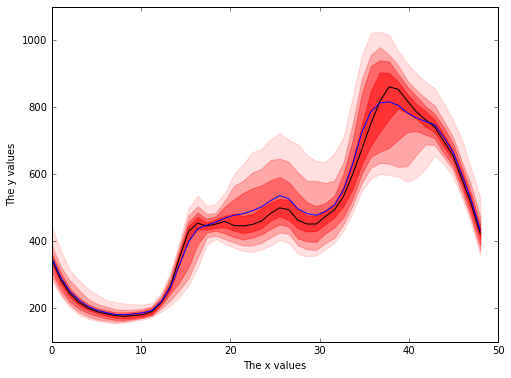

In [6]:
qua1 = np.percentile(aggregated_load,10, axis = 0)
qua2 = np.percentile(aggregated_load,20, axis = 0)
qua3 = np.percentile(aggregated_load,30, axis = 0)
qua4 = np.percentile(aggregated_load,40, axis = 0)
qua5 = np.percentile(aggregated_load,50, axis = 0)
qua6 = np.percentile(aggregated_load,60, axis = 0)
qua7 = np.percentile(aggregated_load,70, axis = 0)
qua8 = np.percentile(aggregated_load,80, axis = 0)
qua9 = np.percentile(aggregated_load,90, axis = 0)
#plot(x,qua1,x,qua3,x,qua5,x,qua7,x,qua9)
N = 1
x = np.linspace(0, 48, 48)
vals = [1,2,3,4] # Values to iterate over and add/subtract from y.
plt.rc('font', family='serif')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

for i, val in enumerate(vals):
    alpha = 0.5*(i+1)/len(vals) # Modify the alpha value for each iteration.
    if i == 0:
        ax.fill_between(x, list(qua9), list(qua1), color='red', alpha=alpha)
    elif i == 1:
        ax.fill_between(x, list(qua8), list(qua2), color='red', alpha=alpha)
    elif i == 2:
        ax.fill_between(x, list(qua7), list(qua3), color='red', alpha=alpha)
    else:
        ax.fill_between(x, list(qua6), list(qua4), color='red', alpha=alpha)

ax.plot(x, qua5, color='black') # Plot the original signal
ax.plot(x, average_load, color = 'b')
plt.show()

In [7]:
def inspect_sysload(sysL):
    assert(sysL.shape[0] > 1)
    assert(sysL.shape[1] == 48)
    Exp = np.mean(sysL, axis = 0)
    peak_mean = np.max(Exp)
    residual = sysL - Exp
    uncer = np.std(residual)
    peak = np.max(sysL)
    return peak_mean, peak, uncer

In [8]:
# start the optimization part, first define parameters of the optimization
# battery parameters: ....
price = np.array(pd.read_csv('pr.csv'))
#define parameters of battery storage and programming
SoCini = 0
SoCmin = 0.3-0.5
SoCmax = 0.9-0.5
Batcap = 12  # kWh
Pmax = 1.5
Pmin = 0-1.5
Efc = 0.99
Efd = 0.9
T = 0.5
HomePG = 5 # home and grid max power
penetration_rate = 0.20

In [ ]:
import scipy.optimize as opt
def optim(demand):
    # OBJ
    def obj(x): # obj = price * Time_duration * (Pt + demand)
        part1 = np.dot(price.T, x + demand)*T
        ret = np.sum(part1)
        return ret
    # CONS 1: # Pt >= P_discharge_limit
    def con1(x): 
        return x - Pmin
    # CONS 2: # Pt <= P_charge_limit
    def con2(x): 
        return Pmax - x
    # CONS 3: # Et >= Emin, Einit = 0.5*cap, Elast = 0.5*cap
    Emin = np.ones(48)*Batcap*SoCmin
    Emin[-1] = 0
    Emax = 0 - Emin
    # define Energy function
    def Energy(x):
        a = np.ones((48,48))
        lower_tri = np.tril(a, k=0)
        Ene = np.matmul(lower_tri,x)*T
        return Ene
    def con3(x):
        return Energy(x) - Emin
    def con4(x):
        return Emax - Energy(x)
    # do not sell energy, that is lose energy is bad
    def con5(x):
        return demand + x
    # max power of the home, or grid
    def con6(x):
        return HomePG - demand - x
    # constraints list
    cons = ({'type': 'ineq', 'fun': con1},
           {'type': 'ineq', 'fun': con2},
           {'type': 'ineq', 'fun': con3},
           {'type': 'ineq', 'fun': con4},
           {'type': 'ineq', 'fun': con5},
           {'type': 'ineq', 'fun': con6})
    x0 = np.zeros(48)  # pick any starting point
    res = opt.minimize(fun=obj, x0=np.array(x0), method='cobyla', constraints=cons, options={'catol': 1e-6})
    return res
def optim2(demand, change, limit):
    # OBJ
    def obj(x): # obj = price * Time_duration * (Pt + demand)
        part1 = np.abs(x + change)
        ret = np.sum(part1)
        return ret
    # CONS 1: # Pt >= P_discharge_limit
    def con1(x): 
        return x - Pmin
    # CONS 2: # Pt <= P_charge_limit
    def con2(x): 
        return Pmax - x
    # CONS 3: # Et >= Emin, Einit = 0.5*cap, Elast = 0.5*cap
    Emin = np.ones(48)*Batcap*SoCmin
    Emin[-1] = 0
    Emax = 0 - Emin
    # define Energy function
    def Energy(x):
        a = np.ones((48,48))
        lower_tri = np.tril(a, k=0)
        Ene = np.matmul(lower_tri,x)*T
        return Ene
    def con3(x):
        return Energy(x) - Emin
    def con4(x):
        return Emax - Energy(x)
    # do not sell energy, that is lose energy is bad
    def con5(x):
        return demand + x
    # max power of the home, or grid
    def con6(x):
        return HomePG - demand - x
    def con7(x):
        part1 = np.dot(price.T, x + demand)*T
        ret = np.sum(part1)
        return limit - ret
    # constraints list
    cons = ({'type': 'ineq', 'fun': con1},
           {'type': 'ineq', 'fun': con2},
           {'type': 'ineq', 'fun': con3},
           {'type': 'ineq', 'fun': con4},
           {'type': 'ineq', 'fun': con5},
           {'type': 'ineq', 'fun': con6},
           {'type': 'ineq', 'fun': con7})
    x0 = np.zeros(48)  # pick any starting point
    res = opt.minimize(fun=obj, x0=np.array(x0), method='cobyla', constraints=cons, options={'catol': 1e-6})
    return res
def optim3(demand, limit):
    # OBJ
    def obj(x): # obj = price * Time_duration * (Pt + demand)
        ret = np.std(x + demand)
        return ret
    # CONS 1: # Pt >= P_discharge_limit
    def con1(x): 
        return x - Pmin
    # CONS 2: # Pt <= P_charge_limit
    def con2(x): 
        return Pmax - x
    # CONS 3: # Et >= Emin, Einit = 0.5*cap, Elast = 0.5*cap
    Emin = np.ones(48)*Batcap*SoCmin
    Emin[-1] = 0
    Emax = 0 - Emin
    # define Energy function
    def Energy(x):
        a = np.ones((48,48))
        lower_tri = np.tril(a, k=0)
        Ene = np.matmul(lower_tri,x)*T
        return Ene
    def con3(x):
        return Energy(x) - Emin
    def con4(x):
        return Emax - Energy(x)
    # do not sell energy, that is lose energy is bad
    def con5(x):
        return demand + x
    # max power of the home, or grid
    def con6(x):
        return HomePG - demand - x
    def con7(x):
        part1 = np.dot(price.T, x + demand)*T
        ret = np.sum(part1)
        return limit - ret
    # constraints list
    cons = ({'type': 'ineq', 'fun': con1},
           {'type': 'ineq', 'fun': con2},
           {'type': 'ineq', 'fun': con3},
           {'type': 'ineq', 'fun': con4},
           {'type': 'ineq', 'fun': con5},
           {'type': 'ineq', 'fun': con6},
           {'type': 'ineq', 'fun': con7})
    x0 = np.zeros(48)  # pick any starting point
    res = opt.minimize(fun=obj, x0=np.array(x0), method='cobyla', constraints=cons, options={'catol': 1e-6})
    return res
def cal_network_uc(GL):
    umlist = []
    tmp1 = uc_process(GL, DCL)
    umlist.append(UncertaintyModel(1,tmp1))
    def uc_analysis(UMList):
        meanlist1 = []
        meanlist2 = []
        meanlist3 = []
        datelist1 = []
        datelist2 = []
        datelist3 = []
        tpntlist1 = []
        tpntlist2 = []
        tpntlist3 = []
        ucmlist = []
        ucdlist = []
        uctlist = []
        count = len(UMList)
        for ind in range(count):
            lv = UMList[ind].getlv()
            if lv == 3:
                (mean1, mean2, mean3, date1, date2, date3, tpnt1, tpnt2, tpnt3, ucm, ucd, uct) = UMList[ind].getuc()
                meanlist1.append(mean1)
                meanlist2.append(mean2)
                meanlist3.append(mean3)
                datelist1.append(date1)
                datelist2.append(date2)
                datelist3.append(date3)
                tpntlist1.append(tpnt1)
                tpntlist2.append(tpnt2)
                tpntlist3.append(tpnt3)
                ucmlist.append(ucm)
                ucdlist.append(ucd)
                uctlist.append(uct)
        return (meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3, ucmlist, ucdlist, uctlist)

    (meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3, ucmlist, ucdlist, uctlist) = uc_analysis(umlist)
    #meanlist1 # for 5 cus, 4 days, only 5 values for each cus, draw line chart in single figure
    #datelist1 # for 5 cus, 4 days, 5 X 4 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along customers, to find uc in different dates
    #tpntlist1 # for 5 cus, 4 days, 5 X 48 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along custoemrs, to find uc in different time points
    print 'Original network uncertainty: ',ucmlist[0]
    return ucmlist[0]
def objcal(x, demand):
    part1 = np.dot(price.T, x + demand)*T
    ret = np.sum(part1)
    return ret

In [ ]:
# one home example --- show how to two targets
print 'original aggregated demand shape: ', aggregated_load.shape # 258, 48
print 'original demand shape: ', db1.shape # 929, 258, 48
new_demand_container = np.zeros((db1.shape[0], db1.shape[1], db1.shape[2]))
new_demand_container2 = np.zeros((db1.shape[0], db1.shape[1], db1.shape[2]))
new_demand_container3 = np.zeros((db1.shape[0], db1.shape[1], db1.shape[2]))
oldcost = 0
newcost = 0
oldcost1 = 0
newcost1 = 0
oldcost2 = 0
newcost2 = 0
oldcost3 = 0
newcost3 = 0
for cus in range(db1.shape[0]):
    for date in range(db1.shape[1]):
        demand = db1[cus, date, :]
        if np.random.rand() < penetration_rate:
            res = optim(demand)
            new_demand = demand + res.x
            new_demand_container[cus,date,:] = new_demand
            oldcost = objcal(0, demand)
            newcost = objcal(res.x, demand)
            oldcost1 = oldcost1 + oldcost
            newcost1 = newcost1 + newcost
            newlimit = 0.8*newcost + 0.2*oldcost
            wc = WaveletClass(demand, 'haar', 'constant', 4)
            wc.decompose()
            (tmp1, tmp2, tmp3) = wc.get_uncertainty(3)
            change = tmp2 + tmp3
            res2 = optim2(demand, change, newlimit)
            res3 = optim3(demand, 0.2*objcal(0, demand) + 0.8*objcal(res.x, demand))
            new_demand2 = demand + res2.x
            new_demand_container2[cus,date,:] = new_demand2
            new_demand3 = demand + res3.x
            new_demand_container3[cus,date,:] = new_demand3
            oldcost2 = oldcost2 + objcal(0, demand)
            newcost2 = newcost2 + objcal(res2.x, demand)
            oldcost3 = oldcost3 + objcal(0, demand)
            newcost3 = newcost3 + objcal(res3.x, demand)
        else:
            new_demand = demand
            new_demand2 = demand
            new_demand3 = demand
            new_demand_container[cus,date,:] = new_demand
            new_demand_container2[cus,date,:] = new_demand2
            new_demand_container3[cus,date,:] = new_demand3
        print 'cus = ',cus,', date index = ',date
aggregated_new_load = np.mean(new_demand_container, axis = 0).reshape(db1.shape[1], db1.shape[2])
aggregated_new_load2 = np.mean(new_demand_container2, axis = 0).reshape(db1.shape[1], db1.shape[2])
aggregated_new_load3 = np.mean(new_demand_container3, axis = 0).reshape(db1.shape[1], db1.shape[2])

original aggregated demand shape:  (258, 48)
original demand shape:  (929, 258, 48)
cus =  0 , date index =  0
cus =  0 , date index =  1
cus =  0 , date index =  2
cus =  0 , date index =  3
cus =  0 , date index =  4
cus =  0 , date index =  5
cus =  0 , date index =  6
cus =  0 , date index =  7
cus =  0 , date index =  8
cus =  0 , date index =  9
cus =  0 , date index =  10
cus =  0 , date index =  11
cus =  0 , date index =  12
cus =  0 , date index =  13
cus =  0 , date index =  14
cus =  0 , date index =  15
cus =  0 , date index =  16
cus =  0 , date index =  17
cus =  0 , date index =  18
cus =  0 , date index =  19
cus =  0 , date index =  20
cus =  0 , date index =  21
cus =  0 , date index =  22
cus =  0 , date index =  23
cus =  0 , date index =  24
cus =  0 , date index =  25
cus =  0 , date index =  26
cus =  0 , date index =  27
cus =  0 , date index =  28
cus =  0 , date index =  29
cus =  0 , date index =  30
cus =  0 , date index =  31
cus =  0 , date index =  32
cu

In [ ]:
tm1, tm2, tm3 = inspect_sysload(aggregated_load)
print 'original demand, peak in TLP = %.4f, peak = %.4f, uncertainty in std = %.4f' % (tm1, tm2, tm3)
tm1, tm2, tm3 = inspect_sysload(aggregated_new_load)
print 'new demand (naive DSR), peak in TLP = %.4f, peak = %.4f, uncertainty in std = %.4f' % (tm1, tm2, tm3)
tm1, tm2, tm3 = inspect_sysload(aggregated_new_load3)
print 'new demand (VAR DSR), peak in TLP = %.4f, peak = %.4f, uncertainty in std = %.4f' % (tm1, tm2, tm3)
tm1, tm2, tm3 = inspect_sysload(aggregated_new_load2)
print 'new demand (pro DSR), peak in TLP = %.4f, peak = %.4f, uncertainty in std = %.4f' % (tm1, tm2, tm3)

In [ ]:
print aggregated_load.shape
plot(range(48), np.mean(aggregated_load, axis = 0), 'black')
plot(range(48), np.mean(aggregated_new_load, axis = 0), 'r')
plot(range(48), np.mean(aggregated_new_load2, axis = 0), 'g')
plot(range(48), np.mean(aggregated_new_load3, axis = 0), 'b')
olduc = cal_network_uc(aggregated_load)
print 'after optimization'
newuc = cal_network_uc(aggregated_new_load)
newuc2 = cal_network_uc(aggregated_new_load2)
newuc3 = cal_network_uc(aggregated_new_load3)

In [ ]:
print 'oldcost for whole network: ', oldcost2
print 'newcost (prior EMS): ', newcost1
print 'newcost (proposed EMS): ', newcost2
print 'newcost (smooth EMS): ', newcost3
print 'cost reduction proposed EMS:{:6.2f}'.format(100*(oldcost2 - newcost2)/oldcost2),'%'
print 'cost reduction smooth EMS:{:6.2f}'.format(100*(oldcost3 - newcost3)/oldcost3),'%'
print 'uncertainty reduction (prior EMS):{:6.2f}'.format(100*(olduc - newuc)/olduc),'%'
print 'uncertainty reduction (proposed EMS):{:6.2f}'.format(100*(olduc - newuc2)/olduc),'%'
print 'uncertainty reduction (smooth EMS):{:6.2f}'.format(100*(olduc - newuc3)/olduc),'%'
print 'uncertainty reduction improvement vs prior EMS:{:6.2f}'.format(100*(newuc - newuc2)/newuc),'%'
print 'uncertainty reduction improvement vs smooth EMS:{:6.2f}'.format(100*(newuc3 - newuc2)/newuc3),'%'

In [ ]:
time2 = time.time()
print time2 - time1